# Caribbean Region Weather Forecasting

## Feature Engineering

In traditional ML, feature engineering involves creating new features to help models learn new patterns. In time series, we need to tell the model what and when something happened. There are four main categories of feature we need to explore and possible create:
- Lag features (memory of the past)
- Rolling statistics (local summaries like rolling average) 
- Time-based features (year, month, day etc)
- Cyclic encodings

Previous notebooks in the same series of forecasting Caribbean Climate:

[01-download-and-data-wrangling.ipynb](01-download-and-data-wrangling.ipynb)

[02-descriptive-stats.ipynb](02-descriptive-stats.ipynb)

[03-EDA-temperature-anomaly.ipynb](03-EDA-temperature-anomaly.ipynb)

[04-EDA-precipitation.ipynb](04-EDA-precipitation.ipynb)

[05-combined-correlations.ipynb](05-combined-correlations.ipynb)

**Author:** Nazgul Sagatova  
**Last updated:** 2025-12-5 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from matplotlib.gridspec import GridSpec
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset

from utils import load_caribbean_weather

df = load_caribbean_weather()

In [4]:
df.head()

,temp_anomaly,precip,year,month,temp_3m,temp_6m,temp_12m,temp_10y,temp_rolling_std,season,rainy_month,decade,precip_log,rain_3m,rain_6m,rain_12m,rain_10y,rain_rolling_std
date,,,,,,,,,,,,,,,,,,
1980-01-01,0.29,44.59,1980,1,NaN,NaN,NaN,NaN,NaN,DJF,False,1980,3.819688,NaN,NaN,NaN,NaN,NaN
1980-02-01,0.31,79.07,1980,2,0.293333,NaN,NaN,NaN,NaN,DJF,False,1980,4.382901,74.413333,NaN,NaN,NaN,NaN
1980-03-01,0.28,99.58,1980,3,0.293333,NaN,NaN,NaN,NaN,MAM,False,1980,4.610953,111.433333,NaN,NaN,NaN,NaN
1980-04-01,0.29,155.65,1980,4,0.306667,0.316667,NaN,NaN,NaN,MAM,True,1980,5.054014,170.713333,165.970,NaN,NaN,NaN
1980-05-01,0.35,256.91,1980,5,0.340000,0.336667,NaN,NaN,NaN,MAM,True,1980,5.552611,257.526667,233.305,NaN,NaN,NaN


### Apply Log Transformations

In previous [notebook](04-EDA-precipitation.ipynb), we log-transformed the Caribbean precipitation values for easier and more meaningful analysis. 
Let's visualise the tranformation along the true raw values.

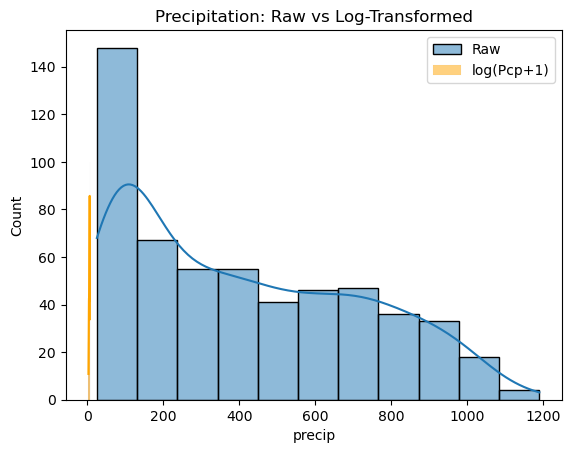

In [5]:
sns.histplot(df['precip'], kde=True, label='Raw', alpha=0.5)
sns.histplot(df['precip_log'], kde=True, color='orange', label='log(Pcp+1)', alpha=0.5)
plt.legend()
plt.title('Precipitation: Raw vs Log-Transformed')
plt.show()

### Standardize temperature anomaly and precipitation.

In [6]:

scaler = StandardScaler()
df[['temp_anomaly_z', 'precip_log_z']] = scaler.fit_transform(df[['temp_anomaly', 'precip_log']])

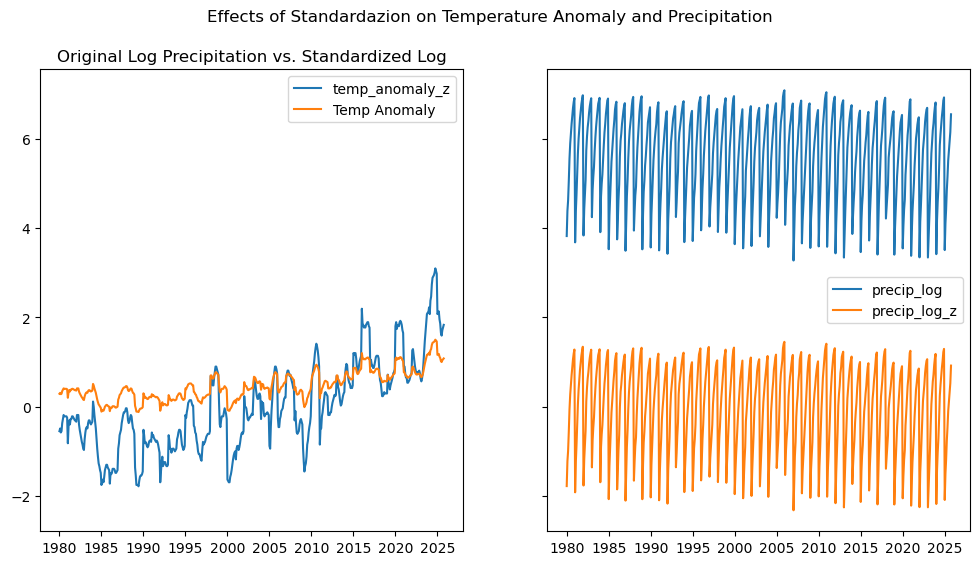

In [7]:
#Visualise the standardization effect

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6), sharey=True)
ax1.plot(df['temp_anomaly_z'], label='temp_anomaly_z')
ax1.plot(df['temp_anomaly'], label='Temp Anomaly')
ax1.legend()
ax1.set_title('Original Temp Anomaly vs. Standardized')

ax2.plot(df['precip_log'], label='precip_log')
ax2.plot(df['precip_log_z'], label='precip_log_z')
ax2.legend()
ax1.set_title('Original Log Precipitation vs. Standardized Log')

plt.suptitle('Effects of Standardazion on Temperature Anomaly and Precipitation')
plt.show()

## Seasonal Decomposition

In order to perform better model fit during forecasting, we need to deseasonalize our time-series data i.e. we need to remove seasonal spikes in temperature anomaly and precipitation to see the real trend. Trends will help us see whether caribbean temperature is truly rising and whether the caribbean is becoming drier in general.

We can utilise the trend to see the real picture of future caribbean climate. Trends will facilitate forecasting as some ML models require deseasoned data.

In this project we will use the STL - Seasonal Decomposition by LOESS.

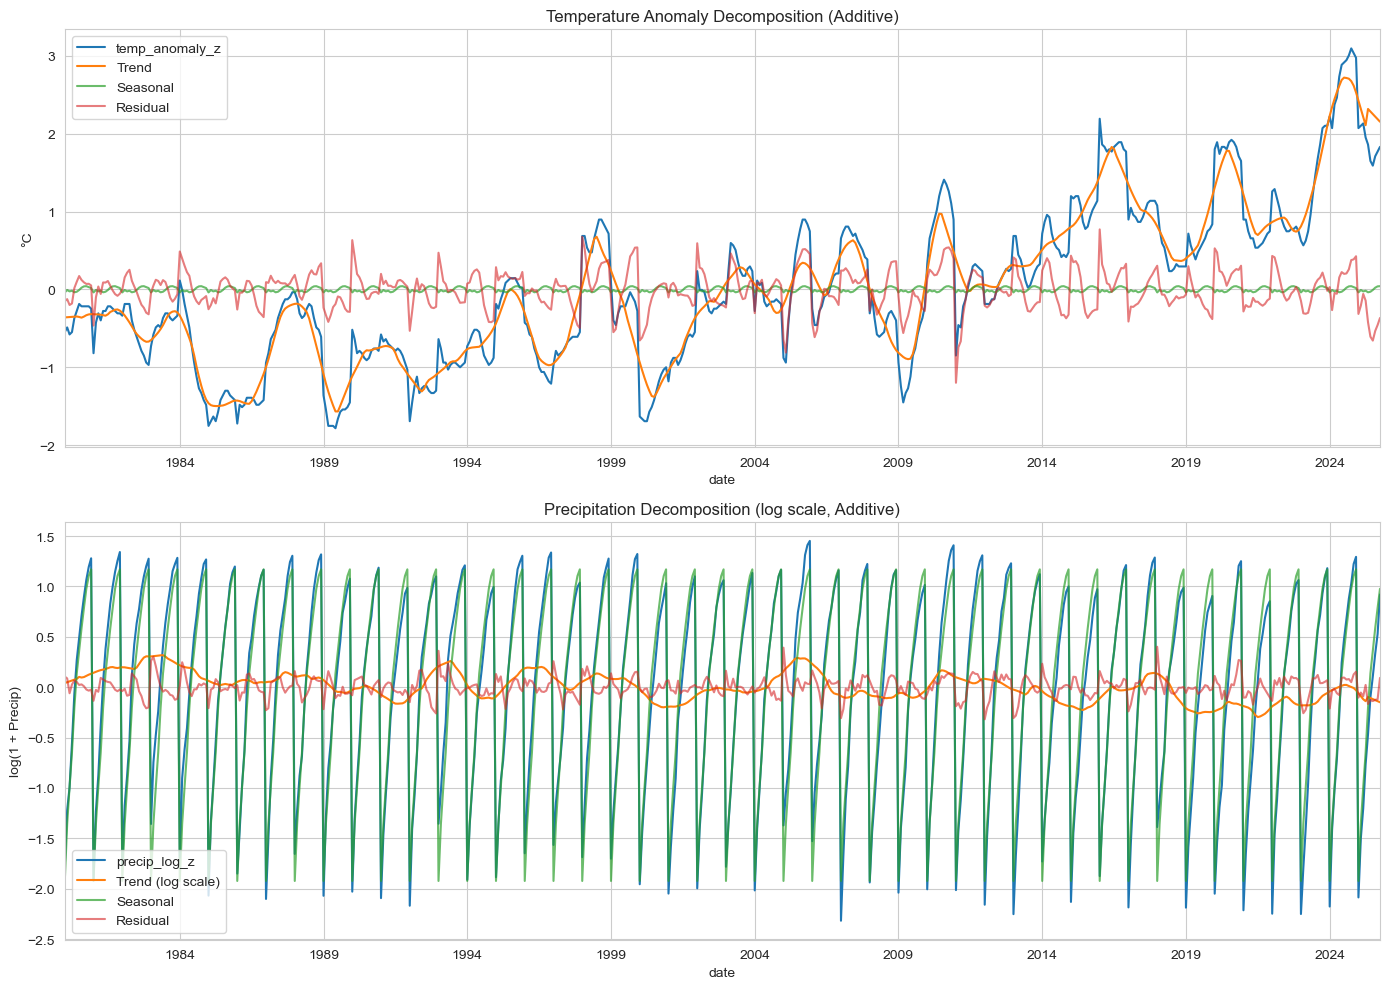

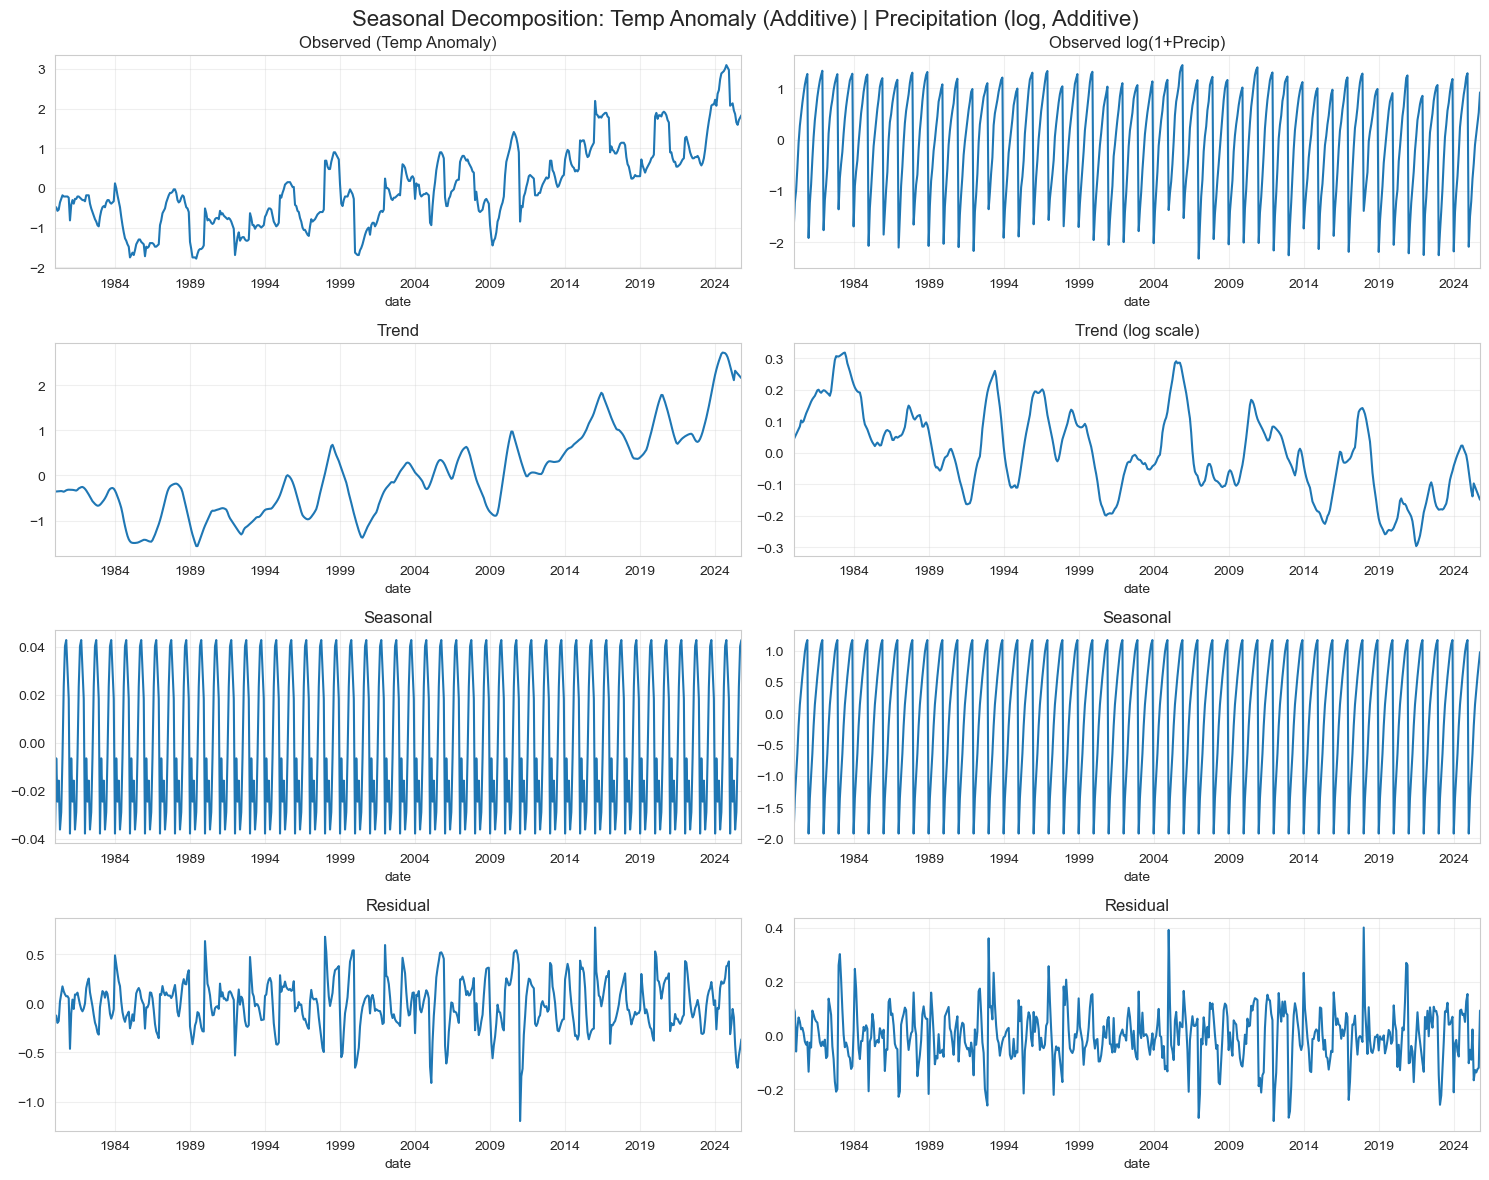

Decomposition complete. Key columns added:
            temp_trend  precip_trend  precip_trend_log
date                                                  
2025-06-01    2.285967      0.897712         -0.107906
2025-07-01    2.253251      0.888456         -0.118270
2025-08-01    2.220534      0.879296         -0.128634
2025-09-01    2.187818      0.870230         -0.138998
2025-10-01    2.155102      0.861257         -0.149362


In [8]:


# Resample to monthly frequency (mean for anomaly, sum for precip)
monthly = df.resample('MS').agg({
    'temp_anomaly_z': 'mean',       # monthly mean anomaly
    'precip_log_z': 'sum'        # monthly total precipitation
}).dropna()

# --- 2. Decomposition: Additive vs Multiplicative ---
# Temperature anomaly → additive (centered around zero)
# Precipitation → multiplicative (positive, skewed, seasonal amplitude grows with mean)

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# --- Temperature Anomaly: Additive Model ---
decomp_temp = seasonal_decompose(monthly['temp_anomaly_z'], 
                                 model='additive', period=12, extrapolate_trend='freq')

ax1 = axes[0]
decomp_temp.observed.plot(ax=ax1, title='Temperature Anomaly Decomposition (Additive)', legend=False)
decomp_temp.trend.plot(ax=ax1, label='Trend')
decomp_temp.seasonal.plot(ax=ax1, label='Seasonal', alpha=0.7)
decomp_temp.resid.plot(ax=ax1, label='Residual', alpha=0.6)
ax1.legend()
ax1.set_ylabel('°C')

# --- Precipitation: Multiplicative Model (log-transform first for stability) ---
# Better: decompose log(1 + precip) → additive on log scale
#precip_log = np.log1p(monthly['Pcp'])

decomp_pcp = seasonal_decompose(monthly['precip_log_z'], 
                                model='additive', period=12, extrapolate_trend='freq')

ax2 = axes[1]
decomp_pcp.observed.plot(ax=ax2, title='Precipitation Decomposition (log scale, Additive)', legend=False)
decomp_pcp.trend.plot(ax=ax2, label='Trend (log scale)')
decomp_pcp.seasonal.plot(ax=ax2, label='Seasonal', alpha=0.7)
decomp_pcp.resid.plot(ax=ax2, label='Residual', alpha=0.6)
ax2.legend()
ax2.set_ylabel('log(1 + Precip)')

plt.tight_layout()
plt.show()

# --- 3. Plot Full Decomposition (Classic 4-panel) ---
fig, axes = plt.subplots(4, 2, figsize=(15, 12))

# Temperature Anomaly
decomp_temp.observed.plot(ax=axes[0,0], title='Observed (Temp Anomaly)')
decomp_temp.trend.plot(ax=axes[1,0], title='Trend')
decomp_temp.seasonal.plot(ax=axes[2,0], title='Seasonal')
decomp_temp.resid.plot(ax=axes[3,0], title='Residual')

# Precipitation (on log scale)
decomp_pcp.observed.plot(ax=axes[0,1], title='Observed log(1+Precip)')
decomp_pcp.trend.plot(ax=axes[1,1], title='Trend (log scale)')
decomp_pcp.seasonal.plot(ax=axes[2,1], title='Seasonal')
decomp_pcp.resid.plot(ax=axes[3,1], title='Residual')

for ax in axes.flat:
    ax.grid(alpha=0.3)

plt.suptitle('Seasonal Decomposition: Temp Anomaly (Additive) | Precipitation (log, Additive)', 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()


# --- 4. Extract and Save Components ---
monthly['temp_trend'] = decomp_temp.trend
monthly['temp_seasonal'] = decomp_temp.seasonal
monthly['temp_residual'] = decomp_temp.resid

monthly['precip_trend_log'] = decomp_pcp.trend
monthly['precip_trend'] = np.exp(decomp_pcp.trend) - 1  # back-transform approx
monthly['precip_seasonal_log'] = decomp_pcp.seasonal
monthly['precip_residual_log'] = decomp_pcp.resid

#Add trends to the main dataframe df
df['temp_trend'] = decomp_temp.trend
df['precip_trend_log'] = decomp_pcp.trend
df['precip_trend'] = np.exp(decomp_pcp.trend)

print("Decomposition complete. Key columns added:")
print(df[['temp_trend', 'precip_trend', 'precip_trend_log']].tail())




### Visualising Deseasoning Effects

For the future modelling and analysis we will consider the trend component of both the temperature anomaly and precipitation as it remove the unnecessary noise and seasonality. Let's visualise the effects of deseasoning.

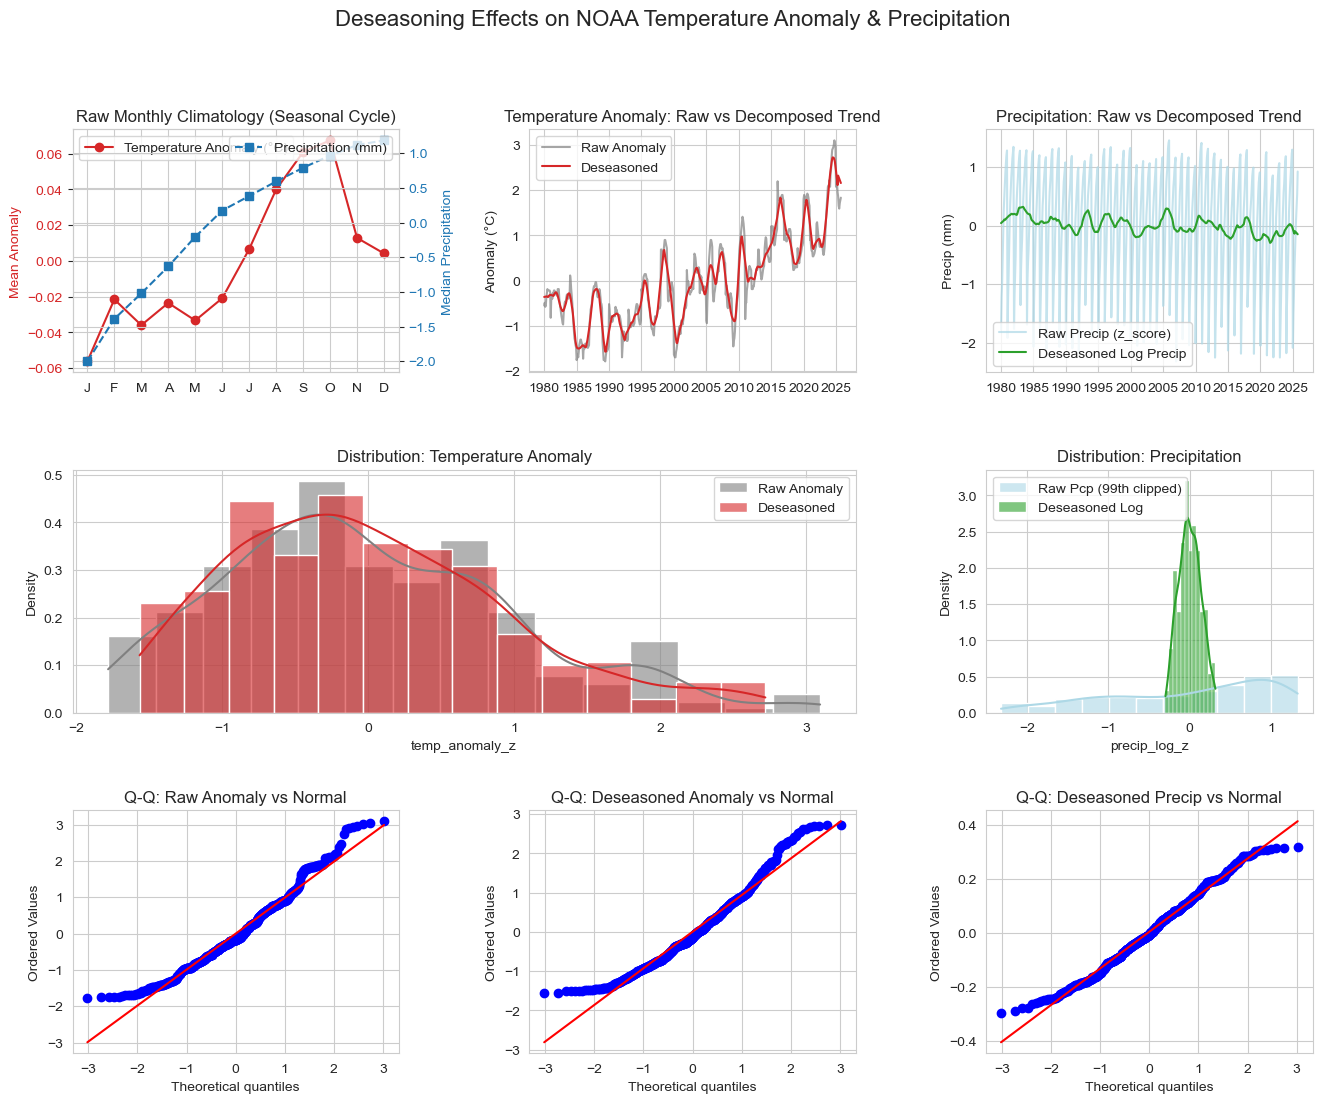

In [9]:

# --- Plot Setup ---
sns.set_style("whitegrid")
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.4, wspace=0.4)

# --- Monthly Climatology (Before) ---
ax1 = fig.add_subplot(gs[0, 0])
monthly_clim_anom = df.groupby('month')['temp_anomaly_z'].mean()
monthly_clim_pcp = df.groupby('month')['precip_log_z'].median()
ax1.plot(monthly_clim_anom.index, monthly_clim_anom, 'o-', label='Temperature Anomaly (°C)', color='tab:red')
ax1.set_ylabel('Mean Anomaly', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_xticks(range(1,13))
ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])

ax1b = ax1.twinx()
ax1b.plot(monthly_clim_pcp.index, monthly_clim_pcp, 's--', label='Precipitation (mm)', color='tab:blue')
ax1b.set_ylabel('Median Precipitation', color='tab:blue')
ax1b.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title('Raw Monthly Climatology (Seasonal Cycle)')
ax1.legend(loc='upper left')
ax1b.legend(loc='upper right')

# --- Time Series: Temp Anomaly ---
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(df.index, df['temp_anomaly_z'], label='Raw Anomaly', alpha=0.7, color='gray')
ax2.plot(df.index, df['temp_trend'], label='Deseasoned', color='tab:red')
ax2.set_title('Temperature Anomaly: Raw vs Decomposed Trend')
ax2.set_ylabel('Anomaly (°C)')
ax2.legend()

# --- Time Series: Pcp ---
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(df.index, df['precip_log_z'], label='Raw Precip (z_score)', alpha=0.7, color='lightblue')
ax3.plot(df.index, df['precip_trend_log'], label='Deseasoned Log Precip', color='tab:green')
ax3.set_title('Precipitation: Raw vs Decomposed Trend')
ax3.set_ylabel('Precip (mm)')
ax3.legend()

# --- Histogram + KDE ---
ax4 = fig.add_subplot(gs[1, :2])
sns.histplot(df['temp_anomaly_z'], kde=True, label='Raw Anomaly', alpha=0.6, color='gray', stat='density')
sns.histplot(df['temp_trend'], kde=True, label='Deseasoned', alpha=0.6, color='tab:red', stat='density')
ax4.set_title('Distribution: Temperature Anomaly')
ax4.legend()

ax5 = fig.add_subplot(gs[1, 2])
sns.histplot(df['precip_log_z'].clip(upper=df['precip_log_z'].quantile(0.99)), kde=True, label='Raw Pcp (99th clipped)', alpha=0.6, color='lightblue', stat='density')
sns.histplot(df['precip_trend_log'].dropna(), kde=True, label='Deseasoned Log', alpha=0.6, color='tab:green', stat='density')
ax5.set_title('Distribution: Precipitation')
ax5.legend()

# --- Q-Q Plot: Normality Check ---
ax6 = fig.add_subplot(gs[2, 0])
stats.probplot(df['temp_anomaly_z'].dropna(), dist="norm", plot=ax6)
ax6.set_title('Q-Q: Raw Anomaly vs Normal')

ax7 = fig.add_subplot(gs[2, 1])
stats.probplot(df['temp_trend'].dropna(), dist="norm", plot=ax7)
ax7.set_title('Q-Q: Deseasoned Anomaly vs Normal')

ax8 = fig.add_subplot(gs[2, 2])
stats.probplot(df['precip_trend_log'].dropna(), dist="norm", plot=ax8)
ax8.set_title('Q-Q: Deseasoned Precip vs Normal')

plt.suptitle('Deseasoning Effects on NOAA Temperature Anomaly & Precipitation', fontsize=16, y=0.98)
plt.show()

In [10]:
# Final save — everyone will read this file
df.to_parquet("../data/processed/caribbean_temp_precip_1980_2025.parquet", index=True)
print("Processed dataset saved → ready for EDA notebooks")

Processed dataset saved → ready for EDA notebooks


## Feature Engineering Insights

### Seasonal Decomposition - Temperature
- Original Temperature Anomalies: the first panel shows the raw temperature anomalies for the Caribbean Region. We observe an overall upward trend with seasonal fluctiation and some noise.
 - Trend Component: the second panel isolates the trend, which reveals clear and steady increase in temperature anomalies over 1980-2025. This suggests that the caribbean is getting hotter.
 - Seasonal Component: the third panel highlights the seasonal effects in climate data. There is a recurring pattern with spikes in both directions, indicating strong seasonality. Temperature usually peaks around summer time. 
 - Residual (Noise) Component: the fourth panel shows the noise after removing the trend and seasonality. This component captures random fluctuations not explained by seasonality and trend. The residuals are not too big, meaning that most of the data was explained by trend and seasonal components.

 ### Seasonal Decomposition - Precipitation
 - Original Data: the raw precipitation for the Caribbean Region show a highly fluctuating picture with spikes in both directions. The trend is not going up nor down, so we cannot firmly say whether it is getting wetther or drier.
 - Trend Component: the trend reveals slight decrease since 1980. This suggests that the caribbean is getting drier in average.
 - Seasonal Component: there is also a recurring pattern indicating string seasonality. Usually, in the Caribbean, rainfall increases during hurrican season June - November.
 - Residual Component: the nois isn't too big, but it reveals extremes i.e. major hurricanes in certain years e.g. 2005, 2018.
